<a href="https://colab.research.google.com/github/ekkune/projects/blob/main/Spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Импортируем библиотеки
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


In [10]:

nltk.download('wordnet')
nltk.download('omw-1.4')



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:

lemmatizer = WordNetLemmatizer()

# Функция для очистки и лемматизации текста
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    # Лемматизация слов
    words = text.split()
    words = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in words]
    return ' '.join(words)

# Функция для извлечения признаков
def extract_text_features(text):
    length = len(text)
    word_count = len(text.split())
    punctuation_count = len(re.findall(r'[.,!?]', text))
    has_url = 1 if re.search(r'http[s]?://|www\.', text.lower()) else 0
    return [length, word_count, punctuation_count, has_url]

# Функция для обучения и оценки модели
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f'{model_name} Cross-Validation Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})')
    y_pred = model.predict(X_test)
    print(f'\n{model_name} Classification Report:')
    print(classification_report(y_test, y_pred))
    return y_pred

# Функция для построения ROC-кривой
def plot_roc_curve(model, X_test, y_test, model_name):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({model_name})')
    plt.legend(loc='lower right')
    plt.show()



In [12]:
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'text']

data['clean_text'] = data['text'].apply(preprocess_text)
data['label'] = data['label'].map({'ham': 0, 'spam': 1})


data[['length', 'word_count', 'punctuation_count', 'has_url']] = pd.DataFrame(
    data['text'].apply(extract_text_features).tolist(), index=data.index
)


X_train, X_test, y_train, y_test = train_test_split(
    data[['clean_text', 'length', 'word_count', 'punctuation_count', 'has_url']],
    data['label'],
    test_size=0.2,
    random_state=42
)



In [13]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train['clean_text'])
X_test_tfidf = vectorizer.transform(X_test['clean_text'])

X_train_features = np.hstack((X_train_tfidf.toarray(), X_train[['length', 'word_count', 'punctuation_count', 'has_url']].values))
X_test_features = np.hstack((X_test_tfidf.toarray(), X_test[['length', 'word_count', 'punctuation_count', 'has_url']].values))


Naive Bayes Cross-Validation Accuracy: 0.96 (+/- 0.00)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.75      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



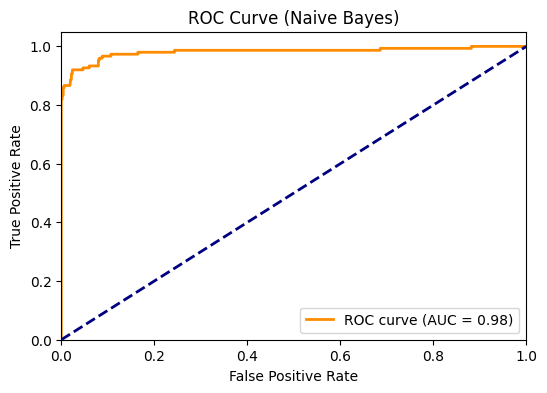

In [14]:
nb_model = MultinomialNB()
nb_pred = train_and_evaluate_model(nb_model, X_train_tfidf, X_test_tfidf, y_train, y_test, 'Naive Bayes')
plot_roc_curve(nb_model, X_test_tfidf, y_test, 'Naive Bayes')

XGBoost Cross-Validation Accuracy: 0.98 (+/- 0.00)

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



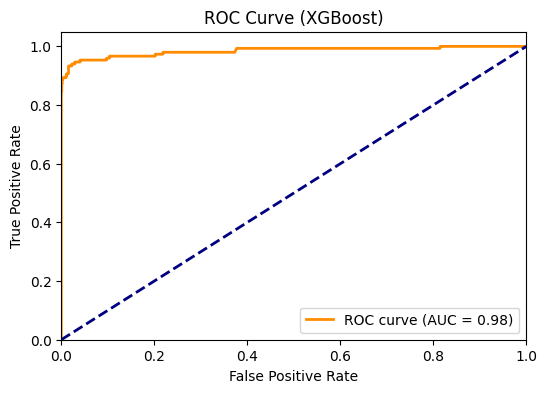

In [15]:
xgb_model = XGBClassifier(scale_pos_weight=sum(y_train == 0) / sum(y_train == 1), random_state=42)
xgb_pred = train_and_evaluate_model(xgb_model, X_train_features, X_test_features, y_train, y_test, 'XGBoost')
plot_roc_curve(xgb_model, X_test_features, y_test, 'XGBoost')

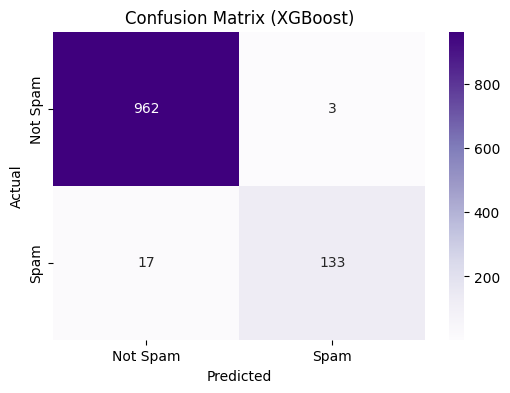

In [16]:
cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()